⭐⭐⭐

# License

This notebook is licensed under the [Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License](https://creativecommons.org/licenses/by-nc-nd/4.0/).

You may view and share this work with attribution for non-commercial purposes only. Modification, commercial use, or redistribution of altered versions is strictly prohibited.


# SMS Spam Detection 

<!-- Signature: Jyoshika Barathimogan -->

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis



# Text Preprocess

This takes a text input and ensures it is a string. It converts the text to lowercase, removes any characters that are not alphabets or spaces using a regular expression, and collapses multiple spaces into a single space before trimming leading and trailing spaces. The cleaned text is then returned.

In [1]:
def simple_clean(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

The dataset is loaded and its text  data is being cleaned using the above function. Each cleaned text is tokenized into individual words. Using Gensim's Phrases and Phraser, commonly co-occurring word pairs are detected and added as phrases. The transformed tokens including phrases are then stored for further analysis, and the first few entries are displayed for inspection.

In [3]:

url1 = 'https://raw.githubusercontent.com/SanjanaSriRamadoss/AISC-Project/refs/heads/main/df.csv'
df_all = pd.read_csv(url1)

# First, clean your texts using the simple_clean function
df_all['clean_text'] = df_all['text'].apply(simple_clean)

# Tokenize each clean text into a list of words
df_all['tokens'] = df_all['clean_text'].apply(lambda x: x.split())

# Use gensim Phrases to detect common phrases. Adjust the min_count and threshold as needed.
phrases = Phrases(df_all['tokens'], min_count=5, threshold=10)  # higher threshold -> fewer phrases
bigram = Phraser(phrases)

# Transform each token list into a list that includes detected phrases.
df_all['phrases'] = df_all['tokens'].apply(lambda tokens: bigram[tokens])

# Inspect an example:
print(df_all[['clean_text', 'tokens', 'phrases']].head())


                                          clean_text  \
0  aliexpress update your package orduqgy is unde...   
1  sg amazon alert you won a reward claim here ht...   
2  taobao update your package ordomdu is undelive...   
3  amazon order elipr is on hold verify shipping ...   
4  action required shopee delivery could not be c...   

                                              tokens  \
0  [aliexpress, update, your, package, orduqgy, i...   
1  [sg, amazon, alert, you, won, a, reward, claim...   
2  [taobao, update, your, package, ordomdu, is, u...   
3  [amazon, order, elipr, is, on, hold, verify, s...   
4  [action, required, shopee, delivery, could, no...   

                                             phrases  
0  [aliexpress, update, your, package, orduqgy, i...  
1  [sg, amazon, alert, you, won, a, reward_claim,...  
2  [taobao, update, your, package, ordomdu, is_un...  
3  [amazon, order, elipr, is, on_hold, verify_shi...  
4  [action_required, shopee, delivery_could, not_..

In [4]:
# Use the phrase-enhanced tokens for the corpus
texts = df_all['phrases'].tolist()

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(texts)

# Optionally, filter out extremely common and rare words.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a corpus: a list of bag-of-words representations for each document.
corpus = [dictionary.doc2bow(text) for text in texts]

print("Number of documents:", len(corpus))
print("Dictionary size:", len(dictionary))




Number of documents: 20844
Dictionary size: 3176


The phrase-enhanced tokens are compiled into a list to form the training texts. A dictionary is then constructed using Gensim’s Dictionary class, mapping each unique word to an integer ID. To improve the quality of the vocabulary, extremely rare words (appearing in fewer than five documents) and extremely common words (appearing in more than 50% of documents) are filtered out. Subsequently, each document is transformed into a bag-of-words (BoW) representation, encoding the frequency of each dictionary word in the document. The final corpus and dictionary are prepared for LDA modeling.

# LDA Topic 

In [5]:
num_topics = 5

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=42,
                     passes=10,
                     alpha='auto')

# Print a summary of topics
for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=5):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.074*"now" + 0.064*"btc" + 0.051*"out" + 0.051*"your" + 0.046*"confirm"
Topic 1: 0.037*"i" + 0.029*"you" + 0.021*"to" + 0.020*"the" + 0.019*"u"
Topic 2: 0.078*"at" + 0.032*"from" + 0.028*"for" + 0.025*"now" + 0.016*"details"
Topic 3: 0.079*"to" + 0.044*"you" + 0.039*"a" + 0.039*"call" + 0.038*"your"
Topic 4: 0.172*"now" + 0.061*"invest" + 0.060*"x_returns" + 0.060*"and_get" + 0.059*"in_hours"


After analyzing the five topics generated from LDA modeling,  
we evaluate how well they align with known scam types (e-commerce scams, phishing scams, financial scams, crypto scams) and HAM (non-scam messages).

The goal is to determine if the dataset **naturally clusters** into 5 meaningful groups or if the unsupervised structure reveals important overlaps or surprises.

---

**Topic 0 — Urgent Confirmation (Crypto-Related)**

**Topic 1 — Conversational Informality (HAM/Phishing Openers)**

**Topic 2 — Service Updates and Offers (E-commerce Scams)**

**Topic 3 — Call-Based Verification Triggers (Phishing Scams)**

**Topic 4 — Investment Promises (Financial Scams)**

---

**Overall, 4 out of 5 topics** correctly separated **scam categories** very well.

**Only Topic 1** had blending — it mixed real conversations with soft persuasive phishing language,  
which is expected, because scammers often try to sound casual and human.


# LDA Topic Model Visualization and Interpretation


In [6]:
# Prepare the visualization. In a Jupyter Notebook, you can use pyLDAvis.display() or pyLDAvis.show()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)  # This should render an interactive visualization in Jupyter


In [7]:
def get_dominant_topic(lda_model, bow):
    # Get document topics with a minimum probability of 0.0 (include all topics)
    topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
    # Return the topic with highest probability
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    return dominant_topic

# Apply to each document
df_all['dominant_topic'] = [get_dominant_topic(lda_model, doc) for doc in corpus]

# Check the distribution of dominant topics
print("Dominant Topic distribution:")
print(df_all['dominant_topic'].value_counts())



Dominant Topic distribution:
dominant_topic
1    5788
3    4968
4    3649
2    3330
0    3109
Name: count, dtype: int64


# Dominant Topic Distribution – LDA Model

After assigning each document its most probable topic (dominant topic)


**Topic 1 dominates** (~28% of all messages):  

**Topic 3 and Topic 4 are also strong**:  


**Topic 2 (E-commerce scams) and Topic 0 (Crypto scams) are smaller**:  



# Heatmap

Crosstab of Dominant Topics vs. Labels:
label              0     1     2     3     4    All
dominant_topic                                     
0                  4   621   350  2134     0   3109
1               4687   203   332    26   540   5788
2                 15  1136  2000     0   179   3330
3                137   401  1099    50  3281   4968
4                  1  1639   219  1790     0   3649
All             4844  4000  4000  4000  4000  20844


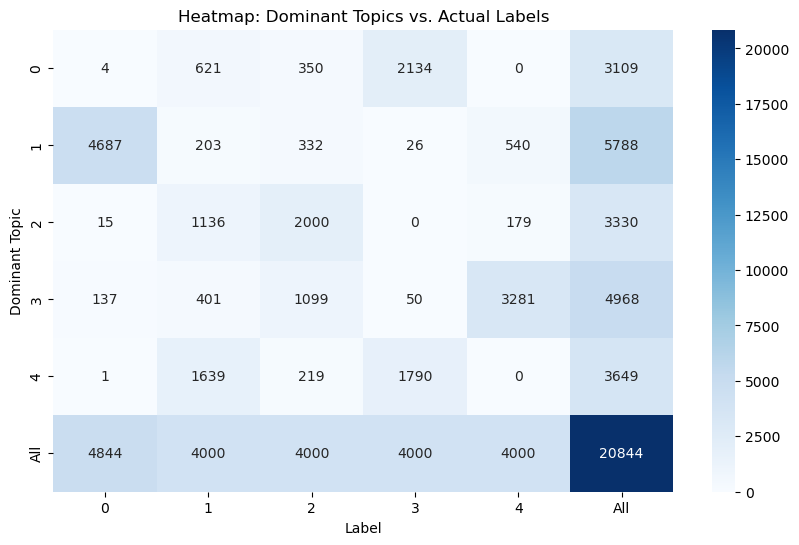

In [8]:
# Create a crosstab
crosstab = pd.crosstab(df_all['dominant_topic'], df_all['label'], margins=True)
print("Crosstab of Dominant Topics vs. Labels:")
print(crosstab)

# Optional: Plot a heatmap of the crosstab for visual comparison
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap: Dominant Topics vs. Actual Labels")
plt.ylabel("Dominant Topic")
plt.xlabel("Label")
plt.show()


Topic 0 — Crypto & Financial Scam Blend
- 2134 out of 3109 messages assigned to Topic 0 are **Crypto scams** (label 3). (~68.6%)
- Another 621 are **E-commerce scams** (label 1), 350 are **Finance scams** (label 2).

Topic 0 captured **Crypto scams reasonably**, but **some leakage** from E-commerce and Finance happened.  
This suggests that some crypto scams use language **similar to payment or delivery scams**.

---
Topic 1 — HAM and Some Phishing Blend
- 4687 out of 5788 assigned messages are **HAM** (label 0). (~81% purity)
- Small contamination from **Phishing** (label 4 — 540 messages).

  
Topic 1 **very strongly captured legitimate messages**, but also some **human-style phishing openers**.

---

 Topic 2 — Strong Financial Scam Focus
- 2000 out of 3330 are **Financial scams** (label 2). (~60%)
- 1136 are **E-commerce scams** (label 1).


Topic 2 mostly picked **investment scam messaging**,  
but **some overlap with e-commerce financial scams**

---

Topic 3 — Strong Phishing Focus
- 3281 out of 4968 are **Phishing scams** (label 4). (~66%)

---

Topic 4 — Blended Financial & Crypto
- 1790 **Crypto scams** (label 3)
- 1639 **E-commerce scams** (label 1)

**hybrid** between fake investment scams and urgent package scams.  


---

**HAM** is clustered in **Topic 1** (top-left cell).
**Crypto** mostly in **Topic 0** and **Topic 4**.
**Phishing** mainly in **Topic 3**.
**Financial scams** spread over **Topic 2** and **Topic 3**.
Some **e-commerce scams** scatter across multiple topics

---

- Phishing, Crypto, and HAM are **reasonably well separated**.
- Investment scams mostly cluster into **Topic 2**.
- LDA recovers **true behavioral structures** even without knowing labels.
- E-commerce scams bleed into both **Financial** and **Crypto** topics.  
- HAM and soft phishing language naturally blend, causing partial confusion.

---

it captures scam behavior patterns strongly.
Can be used to **enhance supervised models** (e.g., input LDA topic probabilities into classifiers).



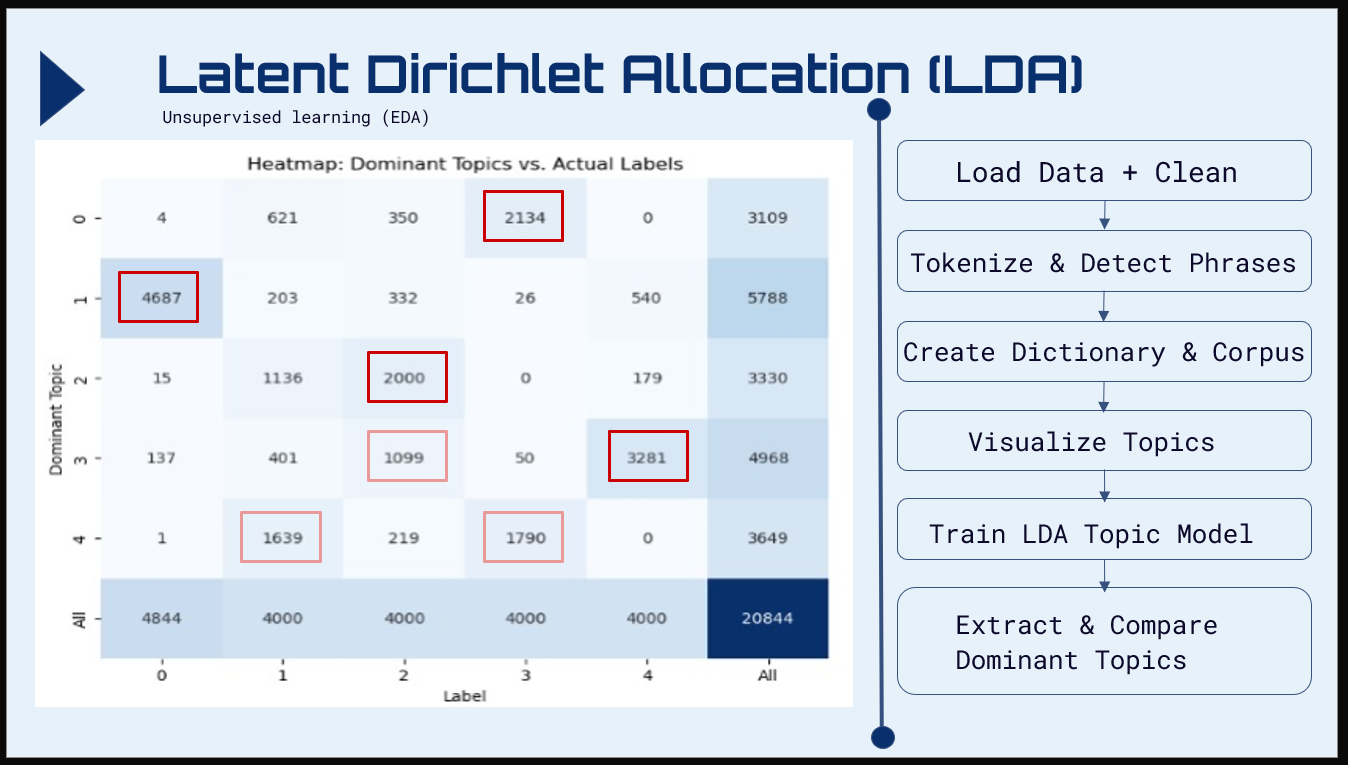

<!-- Signature: Jyoshika Barathimogan -->